## Using R to investigate pairwise FST and nucleotide diversity  
Code adapted slightly from [Max Winston's scripts](https://github.com/mewinsto/Fst)  
This is just exploring one pair of populations. Will write up another notebook with looking at overall Fst and PCA in Adegenet.

An R script with this code can be found at my github [GBS_FST_Pi.R](https://raw.githubusercontent.com/ksil91/Scripts/master/FST/GBS_FST_Pi.R)

Requires: .geno file and .ind file containing 1 pair of populations. See [GBS_File_Conversions notebook](https://github.com/ksil91/2016_Notebook/blob/master/GBS_File_Conversions.ipynb) for code on how to get these files from a Structure (.str) formatted file.

In [23]:
setwd("~/Projects/Ostrea/over10k-min75H32/genos")
library("ggplot2")
library("reshape2")

Pairwise Fst is based on a modified Wright's FST estimator from [Chen et al.,2015](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0135368), where contributions to average FST is weighted by sample size.
![alt text](https://github.com/ksil91/2016_Notebook/raw/master/images/mewinso_fst.png "Fst estimator")
Currently, only SNPs that are genotyped in at least 2 individuals and do not have a MAF of 0 (within those 2 populations) are used to calculate average pairwise FST.

In [8]:
## Function to read in a .geno file. Returns a list with a matrix of genotypes, 
## a vector with population assignments for each individual (0 or 1), and
## a vector with randomized population assignments for sampling null.
makeGenoMatrix <- function(genofile, indfile){
    geno_data = scan(genofile,what = "character")
    L = length(geno_data)
    S = nchar(geno_data[[1]])
    geno_matrix = matrix(data = NA, nrow = S, ncol = L)
    for (i in 1:L){
        genostring = strsplit(geno_data[[i]], split="")
        for (j in 1:S){
        geno_matrix[j,i] = as.numeric(genostring[[1]][j])}
    }
    geno_matrix[geno_matrix == 9] = NA

    ##Read in .ind file in order to get population assignment for genotypes.
    testpop = read.table(indfile,header=FALSE)
    test_vector = testpop$V2
    test_sub = {}
    for (i in 1:S){
        if (test_vector[i] == 1){
            test_sub = c(test_sub,i)}
    }
    ## Creates a null vector, where individuals are randomly assigned to the 2 populations.
    null_vector = sample(c(rep(1,sum(test_vector)),rep(0,S-sum(test_vector))),size=S)
    null_sub = {}
    for (i in 1:S){
        if (null_vector[i] == 1){
            null_sub = c(null_sub,i)}
    }
    return(list(geno_matrix,test_sub,null_sub))
}

In [9]:
##THIS MODULE CALCULATES PI (NUCLEOTIDE DIVERSITY) FOR EACH LOCUS AND WRITES TO A FILE
## Note that this is pi when considering individuals from just 2 populations. Will need to adapt to get pi from 
## entire dataset.
getPi <- function(geno_matrix, suf){
    pi = {}
    L <- ncol(geno_matrix)
    S <- nrow(geno_matrix)
    for (i in 1:L){
        locus = {}
        locus = geno_matrix[,i]
        locus = locus[!is.na(locus)]
        if(length(locus) >= 2){
            locus_sum = 0
            for (j in 2:length(locus)){
                jcount = j - 1
                for (k in 1:jcount){
                    diff = 0
                    diff = abs(locus[j]-locus[k])
                    locus_sum = locus_sum + diff}
            }
            locus_sum = (2*locus_sum)/(length(locus)^2) 
            pi[i] = locus_sum}
        else{
        pi[i] = NA}
    }
    write(pi,file=paste(suf,"pi",sep="."),ncol = 1)
    meanPi = mean(pi, na.rm = TRUE)
    return(meanPi)
}

In [15]:
##THIS MODULE CALCULATES FREQUENCIES AND FST FOR TEST
#Counts and mean frequencies of alleles
getCoverFst <- function(geno_matrix, suf,test_sub,null_sub){
    
    L <- ncol(geno_matrix)
    S <- nrow(geno_matrix)
    geno_means = vector(mode = "numeric", length = L)
    geno_cover = vector(mode = "numeric", length = L)
    geno_cover_p1 = vector(mode = "numeric", length = length(test_sub))
    geno_cover_p2 = vector(mode = "numeric", length = L - length(test_sub))
    for (i in 1:L){
        geno_means[i] = mean(geno_matrix[,i],na.rm=TRUE)/2
    }
    for (i in 1:L){
        geno_cover[i] = sum(!is.na(geno_matrix[,i]))
        geno_cover_p1[i] = sum(!is.na(geno_matrix[test_sub,i]))
        geno_cover_p2[i] = sum(!is.na(geno_matrix[-test_sub,i]))
    }

    #Use test_sub to look at Fst values
    pop_1 = {}
    pop_2 = {}
    pop_mean = {}
        FST = {}
    for (i in 1:L){
        if(geno_cover_p1[i] >= 2 && geno_cover_p2[i] >= 2){
            if(geno_means[i] != 1 && geno_means[i] != 0){
                pop_1[i] = mean(geno_matrix[test_sub,i],na.rm=TRUE)/2
                pop_2[i] = mean(geno_matrix[-test_sub,i],na.rm=TRUE)/2
                #  pop_mean[i] = (pop_1[i] + pop_2[i])/2
                FST[i] = (geno_cover_p1[i]*(abs(geno_means[i] - pop_1[i])^2)+ geno_cover_p2[i]
                          *abs(geno_means[i] - pop_2[i])^2)/(geno_cover[i]*geno_means[i]*(1 - geno_means[i]))
            }
            else{ FST[i] = 0 }
        }
        else{ FST[i] = NA }
    }
    FST = abs(FST)
    meanFST = mean(FST, na.rm = TRUE)
    ##WRITE FST TO FILE
    write(FST,file=paste(suf,"fst",sep="."),ncolumns=1)
    write(geno_cover,file=paste(suf,"genocover",sep="."),ncolumns=1)
    ##THIS MODULE CALCULATES major allele frequency (AF) FOR EACH LOCUS
    af = {}
    for (i in 1:L){
        L_maf = sum(!is.na(geno_matrix[,i]))
        L_sum = sum(geno_matrix[,i],na.rm=TRUE)
        af[i] = L_sum/(2*L_maf)
    }
    #Converts AF to minor allele frequency (MAF)
    maf = {}
    for (i in 1:L){
        if (!is.na(af[i])){
            if (af[i] > 0.5){
                maf[i] = 1 - af[i]} 
            else{ maf[i] = af[i] }
        }
    }
    #WRITE MAF and AF TO FILE
    write(maf,file=paste(suf,"maf",sep="."), ncolumns=1)
    write(af, file=paste(suf,"af",sep="."), ncolumns=1)
    #NUMBER OF INDIVIDUALS WITH SNP (FOR REMOVING SINGLETONS)
    allele_class = {}
    for (i in 1:L){
        allele_class[i] = maf[i]*geno_cover[i]}
    write(allele_class,file=paste(suf,"AC",sep="."),ncolumns=1)
    
    #NULL FST
    geno_cover_p1_N = vector(mode = "numeric", length = length(null_sub))
    geno_cover_p2_N = vector(mode = "numeric", length = L - length(null_sub))

    for (i in 1:L){
        geno_cover[i] = sum(!is.na(geno_matrix[,i]))
        geno_cover_p1_N[i] = sum(!is.na(geno_matrix[null_sub,i]))
        geno_cover_p2_N[i] = sum(!is.na(geno_matrix[-null_sub,i]))
    }

    #Use null_sub to look at Fst values
    pop_1_N = {}
    pop_2_N = {}
    pop_mean = {}
    FST_N = {}
    for (i in 1:L){
        pop_1_N[i] = mean(geno_matrix[null_sub,i],na.rm=TRUE)/2
        pop_2_N[i] = mean(geno_matrix[-null_sub,i],na.rm=TRUE)/2
        #  pop_mean[i] = (pop_1[i] + pop_2[i])/2
        FST_N[i] = (geno_cover_p1_N[i]*(abs(geno_means[i] - pop_1_N[i])^2) + geno_cover_p2_N[i]*abs(geno_means[i] - pop_2_N[i])^2)/(geno_cover[i]*geno_means[i]*(1 - geno_means[i]))
    }
    FST_N = abs(FST_N)

    #WRITE FST NULL TO FILE
    write(FST_N,file=paste(suf,"null_fst",sep="."),ncolumns=1)
    
    return(meanFST)
}

In [11]:
##THIS MODULE CALCULATES H-W EQUILIBRIUM FOR EACH LOCUS
getHW <- function(geno_matrix, suf){
    HW_chi = {}
    L <- ncol(geno_matrix)
    S <- nrow(geno_matrix)
    for (i in 1:L){
        L_maf = sum(!is.na(geno_matrix[,i]))
        p = af[i]
        q = 1 - p
        exp_pp = L_maf*(p^2)
        exp_pq = L_maf*(2*p*q)
        exp_qq = L_maf*(q^2)
        act_pp = sum(geno_matrix[,i] == 2,na.rm=TRUE)
        act_pq = sum(geno_matrix[,i] == 1,na.rm=TRUE)
        act_qq = sum(geno_matrix[,i] == 0,na.rm=TRUE)
        HW_chi[i] = ((act_pp - exp_pp)^2/exp_pp) + ((act_pq - exp_pq)^2/exp_pq) + ((act_qq - exp_qq)^2/exp_qq)
    }
    #WRITE HARDY-WEINBERG CHI-SQUARED STAT (CAN DERIVE p-values FROM THIS)
    write(HW_chi,file=paste(suf,"HW",sep="."),ncolumns=1)
}

Iterate through all pairs of populations in given pop file to calculate pi and fst for each locus. Ouputs to ".pi" and ".fst" files.

In [17]:
poptable <- read.table("../../Pop2Int.txt", header = FALSE)
pops <- unique(as.vector(poptable$V3))
suf <- "over10k-min75H32u"
print(pops)
fst.df <- data.frame(matrix(data=NA,nrow=length(pops),ncol=length(pops)))
rownames(fst.df) <- pops
colnames(fst.df) <- pops

pi.df <- data.frame(matrix(data=NA,nrow=length(pops),ncol=length(pops)))
rownames(pi.df) <- pops
colnames(pi.df) <- pops
popcombos <- unlist(combn(pops,2))
for(i in seq(1,length(popcombos), by = 2)){
    popsuf = paste(suf,popcombos[i],popcombos[i+1],sep="_")
    if(!file.exists(paste(popsuf,"geno",sep = "."))){
        popsuf = paste(suf,popcombos[i+1],popcombos[i],sep="_")}
    glist = makeGenoMatrix(paste(popsuf,"geno",sep = "."),paste(popsuf,"ind",sep="."))
    geno_matrix = glist[[1]]
    test_sub = glist[[2]]
    null_sub = glist[[3]]
    meanPi = getPi(geno_matrix,popsuf)
    meanFST = getCoverFst(geno_matrix, popsuf,test_sub, null_sub)
    fst.df[rownames(fst.df)==popcombos[i],popcombos[i+1]] <- meanFST
    pi.df[rownames(pi.df)==popcombos[i],popcombos[i+1]] <- meanPi
    getHW(geno_matrix,suf)
}
print("done")

 [1] "Victoria"       "Klaskino"       "Barkeley_Sound" "Ladysmith"     
 [5] "Discovery_Bay"  "Liberty_Bay"    "North_Bay"      "Triton_Cove"   
 [9] "Willapa"        "Netarts"        "Yaquina"        "Coos"          
[13] "Humboldt"       "Tomales"        "SF"             "Elkhorn_SLough"
[17] "Mugu_Lagoon"    "San_Diego"      "Conchaphila"   
[1] "done"


In [63]:
fst.df

,Victoria,Klaskino,Barkeley_Sound,Ladysmith,Discovery_Bay,Liberty_Bay,North_Bay,Triton_Cove,Willapa,Netarts,Yaquina,Coos,Humboldt,Tomales,SF,Elkhorn_SLough,Mugu_Lagoon,San_Diego,Conchaphila
Victoria,NA,0.012932630,0.014330883,0.012906105,0.009794823,0.009808500,0.011065482,0.010047581,0.012599945,0.011490895,0.014316719,0.014385674,0.015840579,0.018670813,0.019311092,0.021245887,0.024363640,0.025484952,0.085997263
Klaskino,NA,NA,0.009837800,0.009628778,0.010004882,0.010553212,0.011630020,0.008966416,0.011953221,0.010948568,0.013766112,0.014583298,0.015582286,0.017357017,0.018847208,0.020644451,0.023622068,0.024712225,0.087726505
Barkeley_Sound,NA,NA,NA,0.01232293,0.01300327,0.01309907,0.01359433,0.01160338,0.01371607,0.01345189,0.01536595,0.01631756,0.01697406,0.01823595,0.01736404,0.02003573,0.02075102,0.02123942,0.08148154
Ladysmith,NA,NA,NA,NA,0.009580809,0.009149510,0.011853963,0.008562678,0.012909911,0.012910657,0.014625608,0.015876839,0.015639557,0.017724017,0.018669983,0.018657839,0.022908863,0.024457738,0.084621685
Discovery_Bay,NA,NA,NA,NA,NA,0.007373742,0.008924730,0.007449189,0.010663252,0.010458731,0.013528262,0.013328862,0.014341226,0.017153983,0.017482791,0.016711266,0.020884217,0.021116787,0.077240629
Liberty_Bay,NA,NA,NA,NA,NA,NA,0.007549664,0.007179713,0.012328024,0.010834908,0.013864545,0.013959590,0.015262517,0.017346976,0.018847169,0.017756934,0.022242058,0.022312304,0.084271355
North_Bay,NA,NA,NA,NA,NA,NA,NA,0.009586136,0.011482417,0.011231854,0.013385980,0.013285028,0.014034882,0.017407304,0.017465517,0.017036416,0.020988763,0.021928419,0.080267164
Triton_Cove,NA,NA,NA,NA,NA,NA,NA,NA,0.01104155,0.01023776,0.01317737,0.01313234,0.01374921,0.01601110,0.01704687,0.01775699,0.02133550,0.02284925,0.08357328
Willapa,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.009935905,0.011262233,0.006542950,0.014198203,0.018155759,0.017087841,0.020596725,0.024383899,0.025539767,0.084720016
Netarts,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.009452793,0.011788291,0.014524384,0.016487589,0.016615866,0.018413580,0.022706267,0.024433694,0.084682416


In [81]:
library(dplyr)
# create a vector with letters in the desired order
N_S <- c("Klaskino","Barkeley_Sound","Ladysmith","Victoria","Discovery_Bay","Liberty_Bay","Triton_Cove","Willapa","Netarts","Yaquina","Coos",
      "Humboldt","Tomales","SF","Elkhorn_SLough","Mugu_Lagoon","San_Diego","Conchaphila")

fst.order.df <- fst.df
fst.order.df <- fst.order.df[N_S,N_S]
fst.order.df[1,"Victoria"] <- fst.order.df["Victoria",1]
fst.order.df[2,"Victoria"] <- fst.order.df["Victoria",2]
fst.order.df[3,"Victoria"] <- fst.order.df["Victoria",3]
fst.order.df["Victoria",1] <- NA
fst.order.df["Victoria",2] <- NA
fst.order.df["Victoria",3] <- NA
fst.order.df

,Klaskino,Barkeley_Sound,Ladysmith,Victoria,Discovery_Bay,Liberty_Bay,Triton_Cove,Willapa,Netarts,Yaquina,Coos,Humboldt,Tomales,SF,Elkhorn_SLough,Mugu_Lagoon,San_Diego,Conchaphila
Klaskino,NA,0.009837800,0.009628778,0.012932630,0.010004882,0.010553212,0.008966416,0.011953221,0.010948568,0.013766112,0.014583298,0.015582286,0.017357017,0.018847208,0.020644451,0.023622068,0.024712225,0.087726505
Barkeley_Sound,NA,NA,0.01232293,0.01433088,0.01300327,0.01309907,0.01160338,0.01371607,0.01345189,0.01536595,0.01631756,0.01697406,0.01823595,0.01736404,0.02003573,0.02075102,0.02123942,0.08148154
Ladysmith,NA,NA,NA,0.012906105,0.009580809,0.009149510,0.008562678,0.012909911,0.012910657,0.014625608,0.015876839,0.015639557,0.017724017,0.018669983,0.018657839,0.022908863,0.024457738,0.084621685
Victoria,NA,NA,NA,NA,0.009794823,0.009808500,0.010047581,0.012599945,0.011490895,0.014316719,0.014385674,0.015840579,0.018670813,0.019311092,0.021245887,0.024363640,0.025484952,0.085997263
Discovery_Bay,NA,NA,NA,NA,NA,0.007373742,0.007449189,0.010663252,0.010458731,0.013528262,0.013328862,0.014341226,0.017153983,0.017482791,0.016711266,0.020884217,0.021116787,0.077240629
Liberty_Bay,NA,NA,NA,NA,NA,NA,0.007179713,0.012328024,0.010834908,0.013864545,0.013959590,0.015262517,0.017346976,0.018847169,0.017756934,0.022242058,0.022312304,0.084271355
Triton_Cove,NA,NA,NA,NA,NA,NA,NA,0.01104155,0.01023776,0.01317737,0.01313234,0.01374921,0.01601110,0.01704687,0.01775699,0.02133550,0.02284925,0.08357328
Willapa,NA,NA,NA,NA,NA,NA,NA,NA,0.009935905,0.011262233,0.006542950,0.014198203,0.018155759,0.017087841,0.020596725,0.024383899,0.025539767,0.084720016
Netarts,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.009452793,0.011788291,0.014524384,0.016487589,0.016615866,0.018413580,0.022706267,0.024433694,0.084682416
Yaquina,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.01351438,0.01483111,0.01425602,0.01423938,0.01638149,0.01925289,0.02086745,0.07831232


In [85]:
#m75h25maf0 <- read.table("p8r5maf0/over10k-BCWA-min75H25.fst_summary.tsv",row.names=1,sep="\t",header=TRUE,fill=TRUE)
fst.mat <- data.matrix(fst.order.df)
fst.noc.mat <- data.matrix(fst.order.df[c(1:17),c(1:17)])
melted <- melt(fst.mat, na.rm =TRUE)
melted.noc <- melt(fst.noc.mat, na.rm = TRUE)

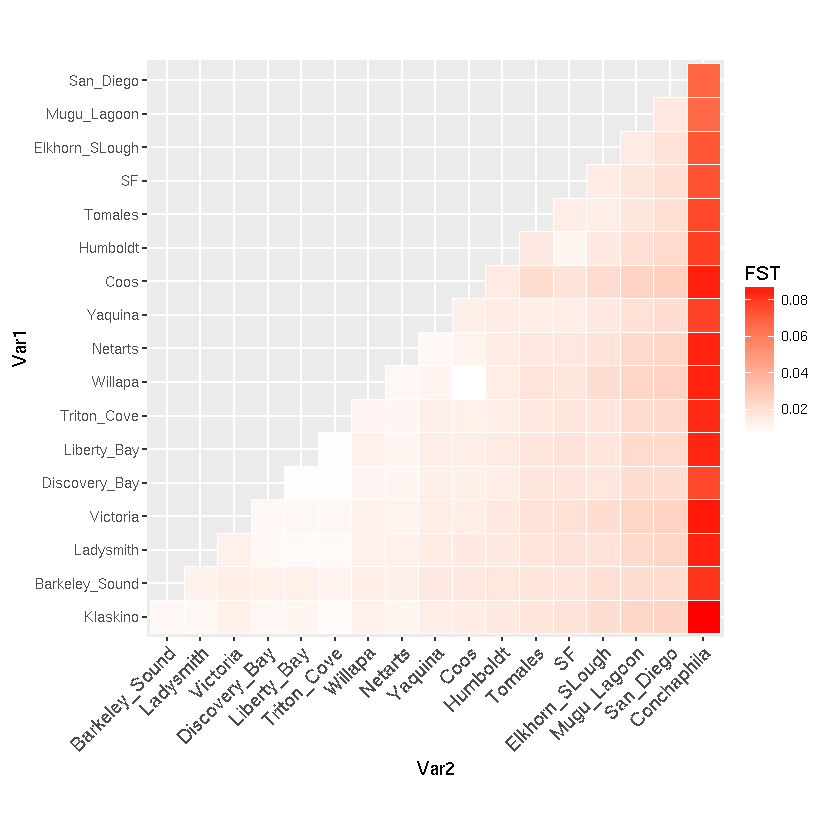

In [83]:
ggplot(data = melted, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient(low = "white", high = "red", 
   name="FST")  +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+ coord_fixed()

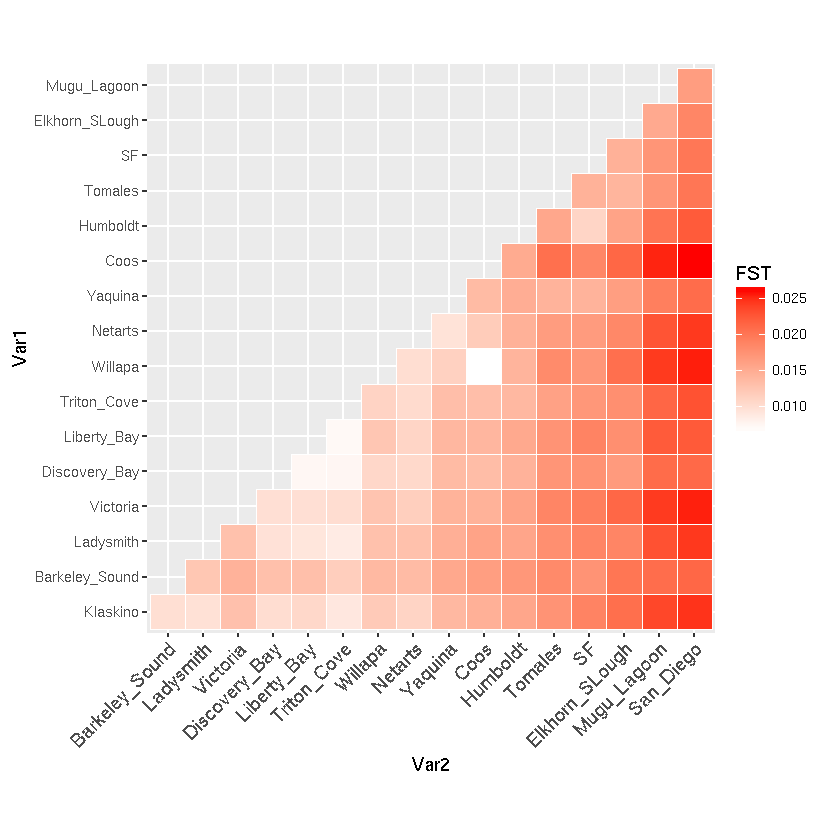

In [88]:
ggplot(data = melted.noc, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient(low = "white", high = "red", 
   name="FST")  +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+ coord_fixed()

## Plotting Results
Lets take a look at one pair of populations.

In [90]:
## Create matricx with all data
library(ggplot2)
pi = read.table("over10k-min75H32u_Victoria_San_Diego.pi")
f_null = read.table("over10k-min75H32u_Victoria_San_Diego.null_fst")
f_test = read.table("over10k-min75H32u_Victoria_San_Diego.fst")
cover_test = read.table("over10k-min75H32u_Victoria_San_Diego.genocover") 
af = read.table("over10k-min75H32u_Victoria_San_Diego.af")
#HW_chi = read.table("over10k-min75H32u_Victoria_San_Diego.HW")
allele_class = read.table("over10k-min75H32u_Victoria_San_Diego.AC")

FST_data = cbind(f_null,f_test,cover_test,pi,af,allele_class)
#names(FST_data) = c("F_null","F_test","Cover","Pi","AF","HW","AC")
names(FST_data) = c("F_null","F_test","Cover","Pi","AF","AC")

In [112]:
##SUBSETS FST DATA INTO COVERAGE GROUPS
for (i in min(cover_test):max(cover_test)){
    name = paste("FST_data_cover_",i, sep = "")
    assign(name,subset(FST_data, cover_test == i))
}
#SUBSETS FST DATA INTO GROUPS WITH FST > 0.3
FST_data_HT = subset(FST_data, F_test > 0.5)
FST_data_HN = subset(FST_data, F_null > 0.5)

#SUBSETS FST DATA INTO GROUPS WITH FST < 0.1
FST_data_LT = subset(FST_data, F_test < 0.1)
FST_data_LN = subset(FST_data, F_null < 0.1)

#SUBSETS FST DATA INTO GROUPS WITH Pi > 0.5
Hi_Pi = subset(FST_data, Pi > 0.5)
Lo_Pi = subset(FST_data, Pi < 0.2)

Pi_cat = cut(FST_data$Pi,breaks=10)

#SUBSETS FST DATA TO EXCLUDE SINGLETONS (AC == 1)
FST_data_AC = subset(FST_data, allele_class > 1)
FST_data_AC_HT = subset(FST_data_AC, F_test == 1)

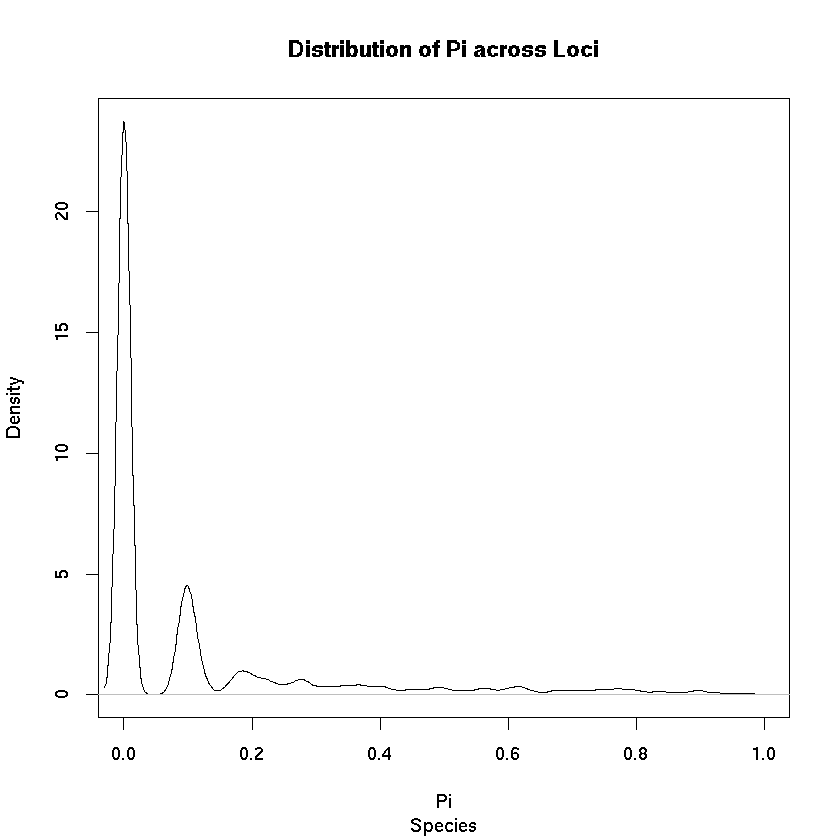

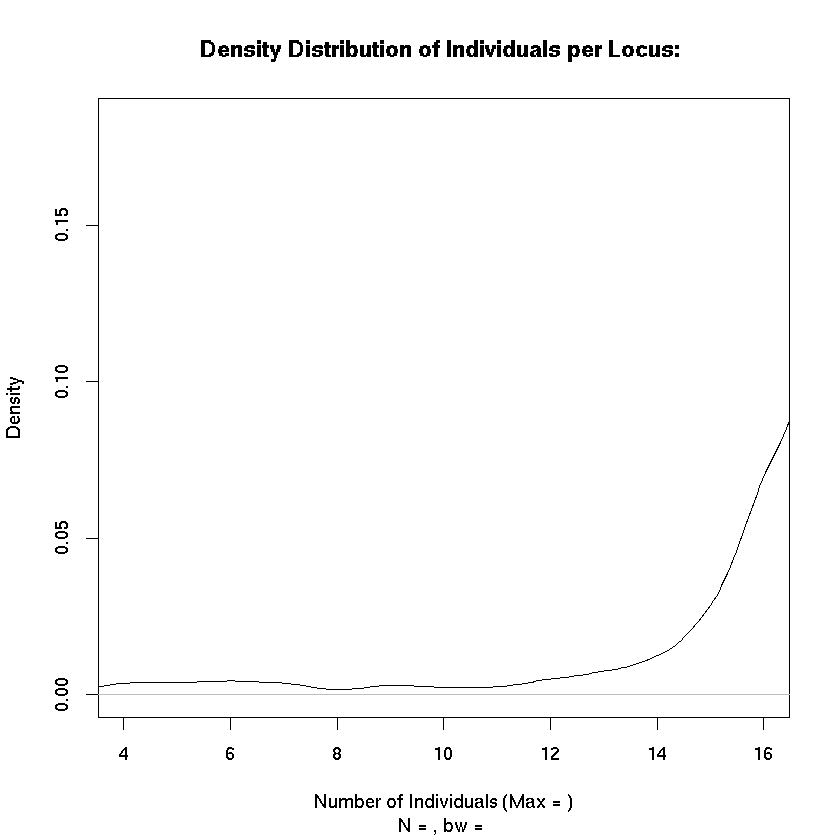

In [106]:
#Plot densities of these values
plot(density(FST_data$Pi,bw=0.01, na.rm=TRUE),xlim=c(0,1),main="Distribution of Pi across Loci", xlab="Pi", sub="Species")
plot(density(FST_data$Cover,bw=0.5),xlim=c(4,16),main="Density Distribution of Individuals per Locus: ", xlab="Number of Individuals (Max = )",sub="N = , bw = ")


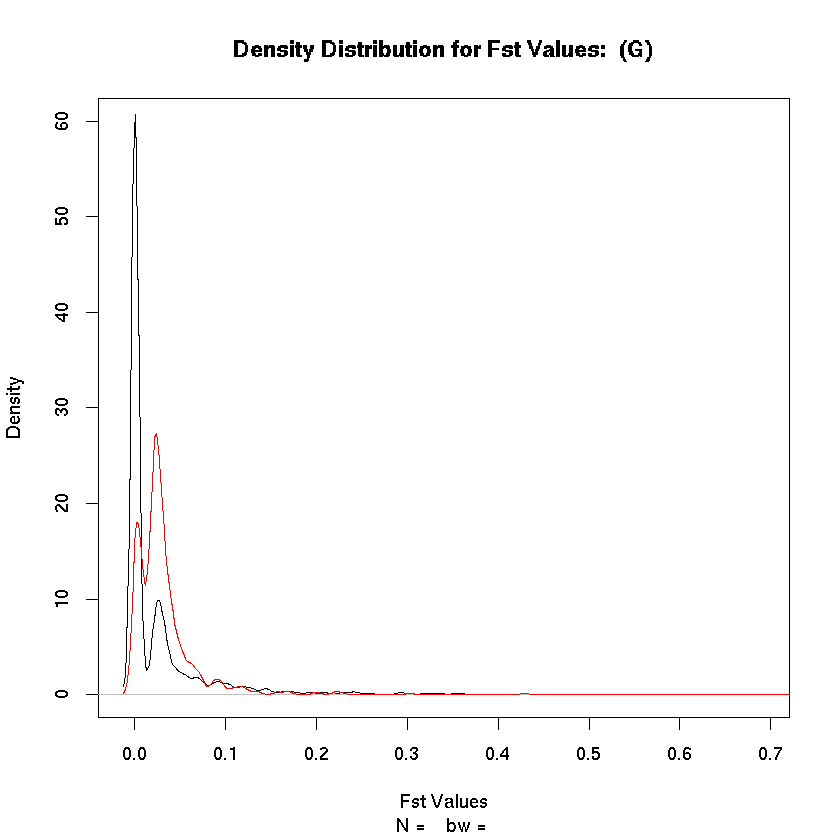

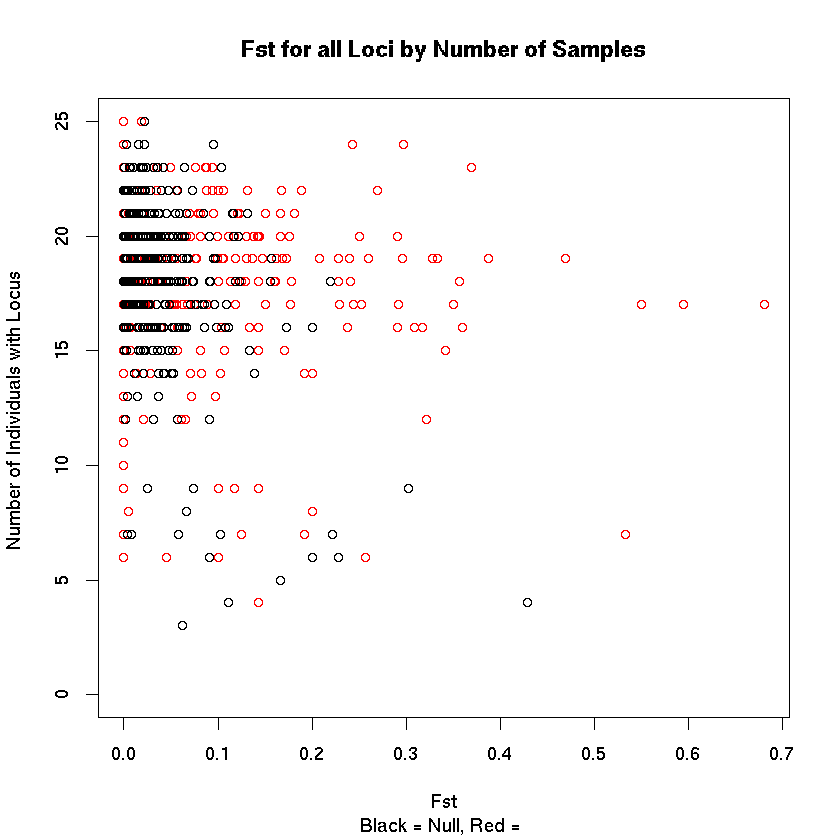

In [107]:
##PLOT FST AGAINST GENO_COVER
plot(density(FST_data$F_test,na.rm=TRUE,bw=.004),ylim=c(0,60),main="Density Distribution for Fst Values:  (G)",xlab="Fst Values", sub = "N =    bw = ")
lines(density(FST_data$F_null,na.rm=TRUE,bw=.004),col=2)

plot(FST_data$F_test,FST_data$Cover,col=2,main="Fst for all Loci by Number of Samples",xlab="Fst",ylab="Number of Individuals with Locus ",sub="Black = Null, Red = ")
points(FST_data$F_null,FST_data$Cover)

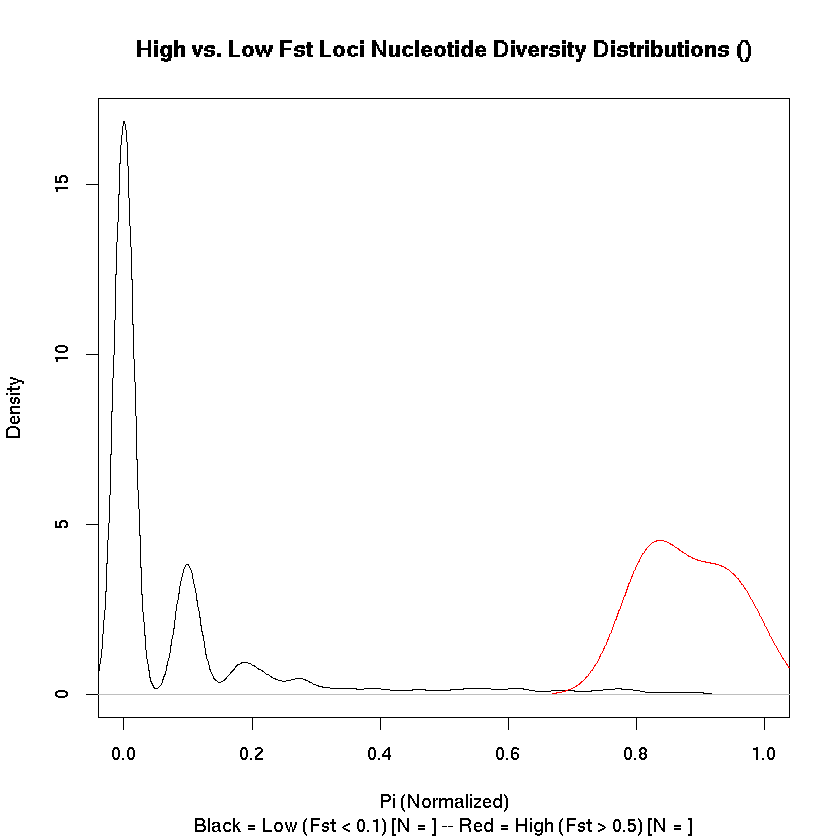

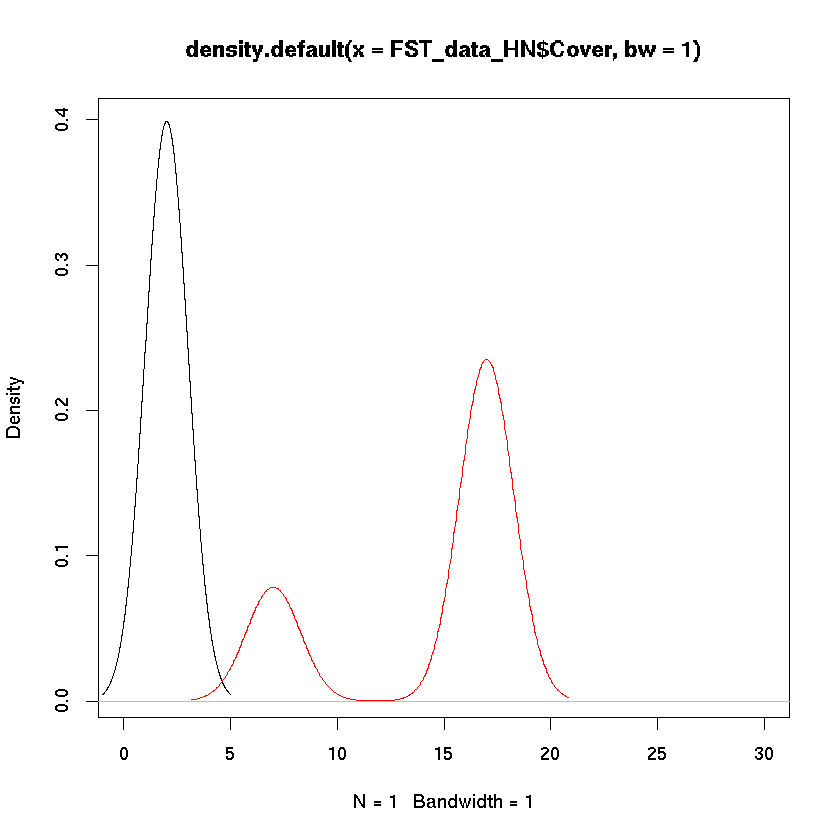

In [110]:
#PLOTS NUCLEOTIDE DIVERSITY FOR HIGH VS. LOW FST LOCI
plot(density(FST_data_LT$Pi),main="High vs. Low Fst Loci Nucleotide Diversity Distributions ()",xlim = c(0,1), 
     xlab="Pi (Normalized?)",sub="Black = Low (Fst < 0.1) [N = ] -- Red = High (Fst > 0.5) [N = ]")
lines(density(FST_data_HT$Pi),col=2)

plot(density(FST_data_HN$Cover,bw=1),xlim=c(0,30))
lines(density(FST_data_HT$Cover),col=2)

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

Warning message:
“Removed 12 rows containing missing values (geom_point).”Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

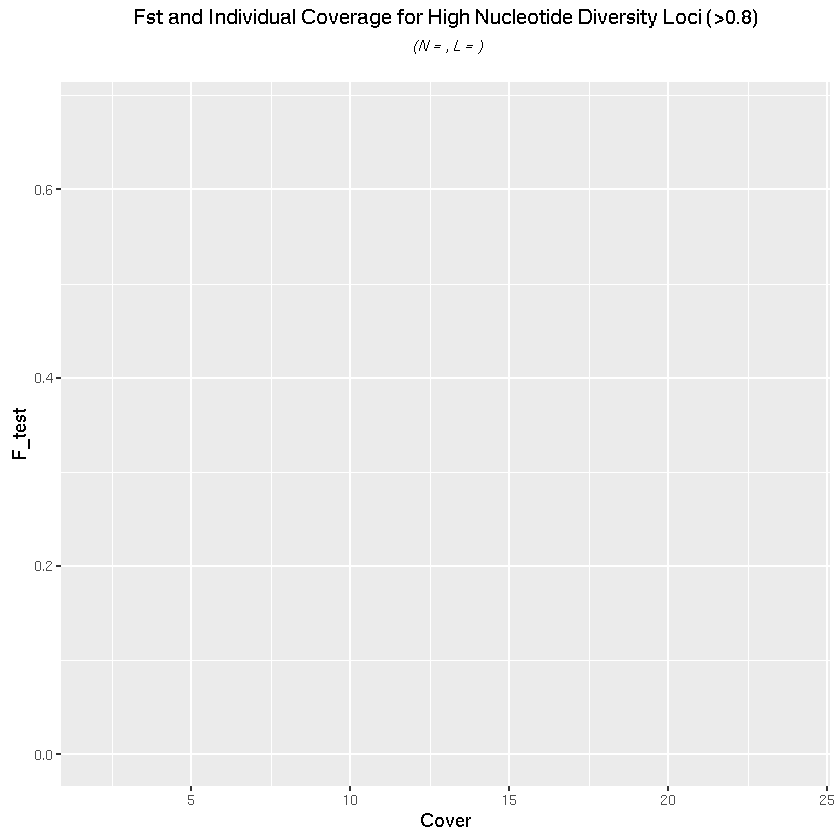

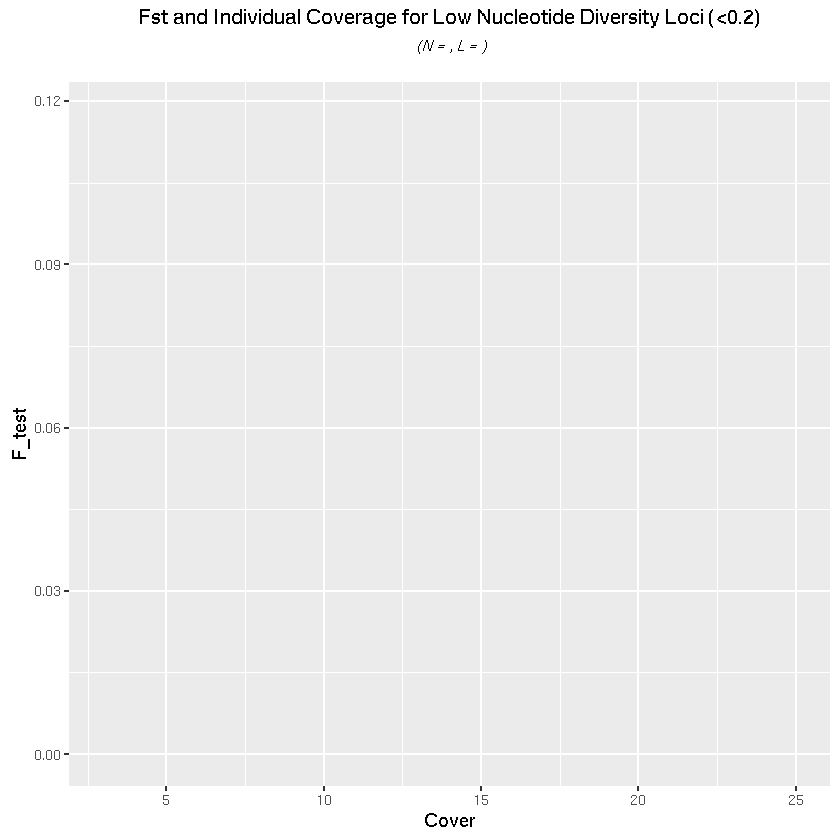

In [115]:
##Plots LOW DIVERSITY AND HIGH DIVERSITY LOCI
# Can't get this to work just yet...
HP = ggplot(Hi_Pi, aes(x = Cover, y = F_test))
HP + geom_point(alpha = 0.05) + ggtitle(expression(atop("Fst and Individual Coverage for High Nucleotide Diversity Loci (>0.8)", atop(italic(" (N = , L = )", "")))))

HPlow = ggplot(Lo_Pi, aes(x = Cover, y = F_test))
HPlow + geom_point(alpha = 0.05) + ggtitle(expression(atop("Fst and Individual Coverage for Low Nucleotide Diversity Loci (<0.2)", atop(italic(" (N = , L = )", "")))))


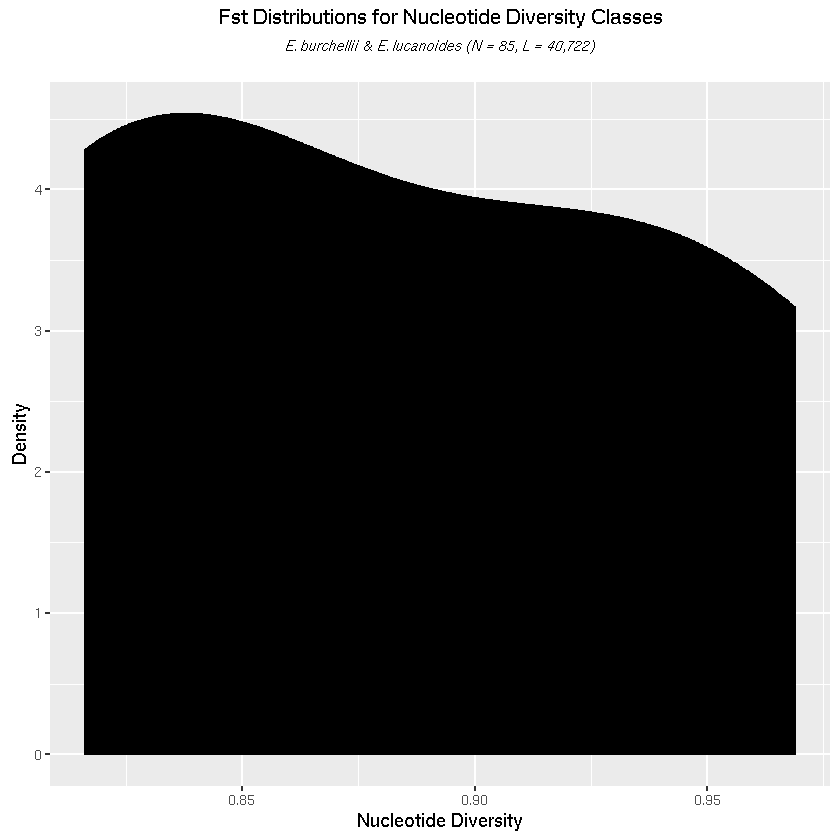

In [117]:
##PLOTS DENSITY DISTRIBUTION OF NUCLEOTIDE DIVERSITY FOR FST > 0.5
TOP_DENS = ggplot(FST_data_HT, aes(x = Pi))
TOP_DENS + geom_density(fill = "black") + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes", atop(italic("E. burchellii & E. lucanoides (N = , L = )", ""))))) + labs(x = "Nucleotide Diversity", y = "Density")


Warning message:
“Removed 1088 rows containing non-finite values (stat_boxplot).”

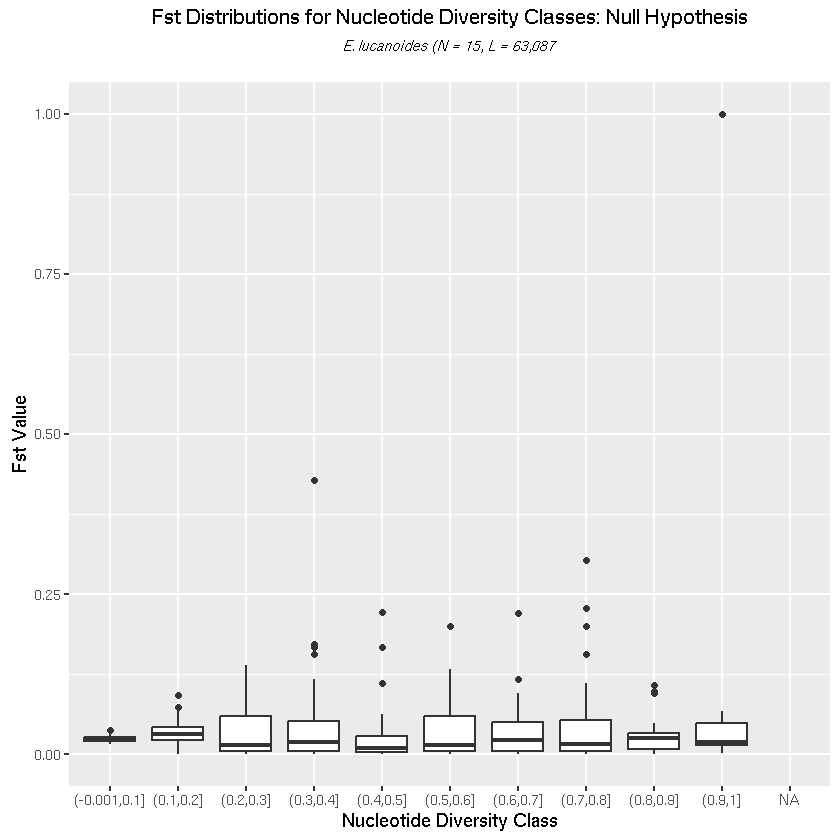

In [118]:
##GGPLOT NUCLEOTIDE DIVERSITY CLASSES AGAINST FST FOR NULL AND TEST
p = ggplot(FST_data, aes(factor(Pi_cat), F_null))

#p + geom_violin() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes",
#atop(italic("E. burchellii (N = 75, L = 168,518)", ""))))) + 
#labs(x = "Nucleotide Diversity Class", y = "Fst Value")

p + geom_boxplot() + ggtitle(expression(atop("Fst Distributions for Nucleotide Diversity Classes: Null Hypothesis", 
atop(italic("E. lucanoides (N = , L = ", ""))))) + labs(x = "Nucleotide Diversity Class", y = "Fst Value")


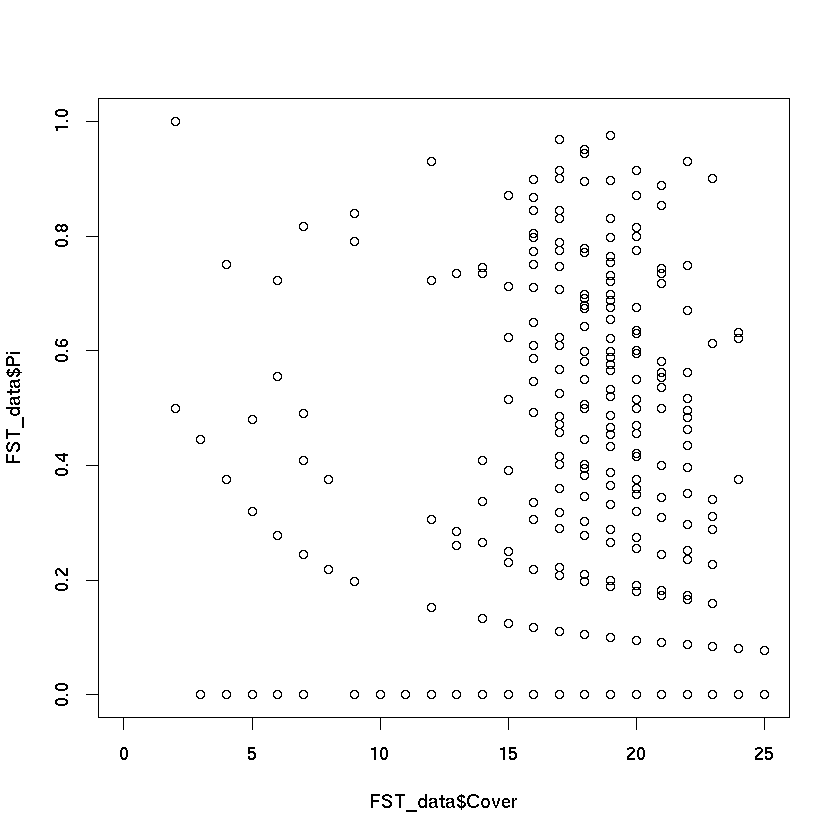

In [119]:
#Plots Pi against Coverage of Individuals
plot(FST_data$Cover,FST_data$Pi)